In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numba as nb
import polars as pl
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data Visualization

Find out which data is given at the beginning

In [29]:
# Paths
folder = "data/nfl-big-data-bowl-2026-prediction/train/"

input_file = folder + "input_2023_w01.csv"
output_file = folder + "output_2023_w01.csv"
game_id = 2023090700
play_id = 101

# Load CSVs
input_df = pl.read_csv(input_file)
output_df = pl.read_csv(output_file)

# Filter for play 1 of game 2023090700
play = input_df.filter((pl.col("game_id") == game_id) & (pl.col("play_id") == play_id))

# Split offense and defense
offense = play.filter(pl.col("player_side") == "Offense")
defense = play.filter(pl.col("player_side") == "Defense")

# Extract positions as NumPy arrays
def extract_arrays(df):
    return df["x"].to_numpy(), df["y"].to_numpy(), df["player_position"].to_numpy()

offense_x, offense_y, offense_pos = extract_arrays(offense)
defense_x, defense_y, defense_pos = extract_arrays(defense)

# Get last frame
last_frame = play.filter(pl.col("frame_id") == play["frame_id"].max())

# Offense last frame
off_last = last_frame.filter(pl.col("player_side") == "Offense")
off_x, off_y = off_last["x"].to_numpy(), off_last["y"].to_numpy()
off_dir = off_last["dir"].to_numpy() - 90


first_frame = play.filter(pl.col("frame_id") == play["frame_id"].min())
receivers = first_frame.filter(pl.col("player_position").is_in(["WR", "TE"]))
line_of_scrimmage_x = np.mean(receivers["x"].to_numpy())

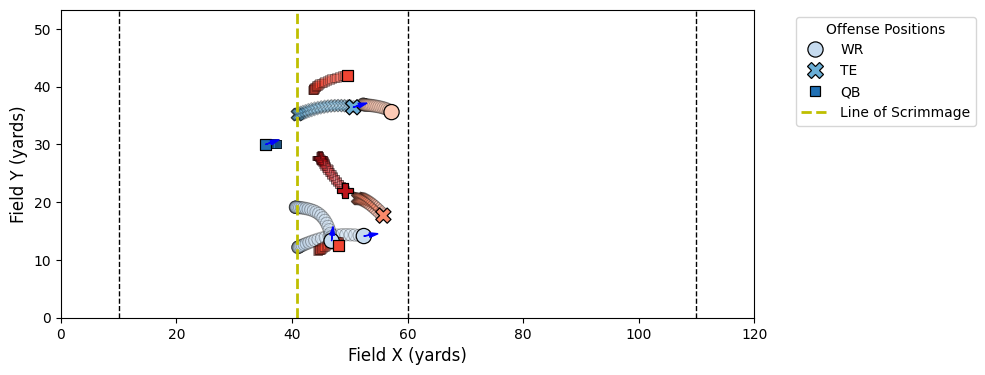

In [30]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# All offense frames (translucent)
for frame_id in play["frame_id"].unique().to_numpy():
    frame = play.filter(pl.col("frame_id") == frame_id)
    x = frame.filter(pl.col("player_side") == "Offense")["x"].to_numpy()
    y = frame.filter(pl.col("player_side") == "Offense")["y"].to_numpy()
    pos = frame.filter(pl.col("player_side") == "Offense")["player_position"].to_numpy()
    sns.scatterplot(x=x, y=y, hue=pos, style=pos, s=80, palette="Blues", marker='o', ax=ax,
                    legend=False, edgecolor='k', alpha=0.3)

# All defense frames (translucent)
for frame_id in play["frame_id"].unique().to_numpy():
    frame = play.filter(pl.col("frame_id") == frame_id)
    x = frame.filter(pl.col("player_side") == "Defense")["x"].to_numpy()
    y = frame.filter(pl.col("player_side") == "Defense")["y"].to_numpy()
    pos = frame.filter(pl.col("player_side") == "Defense")["player_position"].to_numpy()
    sns.scatterplot(x=x, y=y, hue=pos, style=pos, s=80, palette="Reds", marker='^', ax=ax,
                    legend=False, edgecolor='k', alpha=0.3)

# Last frame offense and defense (fully opaque)
# Offense
off_last = last_frame.filter(pl.col("player_side") == "Offense")
off_x, off_y, off_pos = off_last["x"].to_numpy(), off_last["y"].to_numpy(), off_last["player_position"].to_numpy()
sns.scatterplot(x=off_x, y=off_y, hue=off_pos, style=off_pos,
                s=120, palette="Blues", marker='o', ax=ax, legend='full', edgecolor='k', alpha=1)

# Defense
def_last = last_frame.filter(pl.col("player_side") == "Defense")
def_x, def_y, def_pos = def_last["x"].to_numpy(), def_last["y"].to_numpy(), def_last["player_position"].to_numpy()
sns.scatterplot(x=def_x, y=def_y, hue=def_pos, style=def_pos,
                s=120, palette="Reds", marker='^', ax=ax, legend=False, edgecolor='k', alpha=1)

# Field markings
plt.axvline(x=60, color='k', linestyle='--', linewidth=1)    # Midfield
plt.axvline(x=10, color='k', linestyle='--', linewidth=1)    # Endzone 1
plt.axvline(x=110, color='k', linestyle='--', linewidth=1)   # Endzone 2

# Line of Scrimmage
first_frame = play.filter(pl.col("frame_id") == play["frame_id"].min())
receivers = first_frame.filter(pl.col("player_position").is_in(["WR", "TE"]))
line_of_scrimmage_x = np.mean(receivers["x"].to_numpy())
plt.axvline(x=line_of_scrimmage_x, color='y', linewidth=2, linestyle='--', label="Line of Scrimmage")

# Last frame arrows for direction
off_dir = off_last["dir"].to_numpy() - 90
for x, y, angle in zip(off_x, off_y, off_dir):
    dx = np.cos(np.radians(angle))
    dy = np.sin(np.radians(angle))
    ax.arrow(x, y, dx, dy, head_width=0.8, head_length=1.5, color='blue', alpha=1)

# Labels & limits
plt.xlabel("Field X (yards)", fontsize=12)
plt.ylabel("Field Y (yards)", fontsize=12)
plt.xlim(0, 120)
plt.ylim(0, 53.3)
ax.set_aspect('equal', adjustable='box')

# Clean up legend
ax.legend(title='Offense Positions', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# Prediction

In [31]:
from torch.utils.data import Dataset, DataLoader

class PlayDataset(Dataset):
    def __init__(self, X_list, Y_list):
        """
        X_list: list of [n_players, n_frames_pre, n_features] tensors
        Y_list: list of [n_players, n_frames_post, 2] tensors (x,y)
        """
        self.X_list = X_list
        self.Y_list = Y_list

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        X = self.X_list[idx]
        Y = self.Y_list[idx]
        return X, Y
    
class SimplePlayerPredictor(nn.Module):
    def __init__(self, n_features=6, hidden_size=64, n_layers=2, n_future=21):
        super().__init__()
        self.n_future = n_future
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size, 
                            num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # predict x, y per timestep
    def forward(self, x, n_future=None):
        h, _ = self.lstm(x)  # [batch, n_frames, hidden_size]
        h_last = h[:, -1, :]
        if n_future is None:
            n_future = self.n_future
        out = self.fc(h_last).unsqueeze(1).repeat(1, n_future, 1)
        return out


In [32]:
from glob import glob
import polars as pl
import torch
from tqdm import tqdm

folder = "data/nfl-big-data-bowl-2026-prediction/train/"
input_files = sorted(glob(folder + "input_2023_w*.csv"))
output_files = sorted(glob(folder + "output_2023_w*.csv"))

X_list = []
Y_list = []

for input_file, output_file in tqdm(zip(input_files, output_files), total=len(input_files), desc="Processing weeks"):
    # Load week
    df_input = pl.read_csv(input_file)
    df_output = pl.read_csv(output_file)
    
    # Optional: only players to predict
    df_input = df_input.filter(pl.col("player_to_predict") == True)
    
    # Unique game+play
    plays = df_input.select(["game_id","play_id"]).unique()
    plays_list = plays.to_dicts()
    
    for play in tqdm(plays_list, desc=f"Processing {input_file}", leave=False):
        game_id = play["game_id"]
        play_id = play["play_id"]
        
        # Input for this play
        play_input = df_input.filter(
            (pl.col("game_id") == game_id) & (pl.col("play_id") == play_id)
        )
        
        players = play_input.select("nfl_id").unique().to_series().to_list()
        
        # Build input tensor
        player_tensors = []
        for p in players:
            p_data = play_input.filter(pl.col("nfl_id") == p)
            features = p_data.select(["x","y","s","a","dir","o"]).to_numpy()
            player_tensors.append(features)
        X = torch.tensor(player_tensors, dtype=torch.float32)
        
        # Build output tensor
        play_output = df_output.filter(
            (pl.col("game_id") == game_id) & (pl.col("play_id") == play_id)
        )
        Y_player_tensors = []
        for p in players:
            p_out = play_output.filter(pl.col("nfl_id") == p)
            coords = p_out.select(["x","y"]).to_numpy()
            Y_player_tensors.append(coords)
        Y = torch.tensor(Y_player_tensors, dtype=torch.float32)
        
        X_list.append(X)
        Y_list.append(Y)


Processing weeks: 100%|██████████| 18/18 [02:12<00:00,  7.38s/it]


In [33]:
def pad_collate(batch):
    X_list, Y_list = zip(*batch)
    
    max_players = max([x.shape[0] for x in X_list])
    max_frames_pre = max([x.shape[1] for x in X_list])
    max_frames_post = max([y.shape[1] for y in Y_list])
    
    X_batch = []
    Y_batch = []
    
    for X, Y in zip(X_list, Y_list):
        # Pad players
        pad_players = max_players - X.shape[0]
        if pad_players > 0:
            X = torch.cat([X, torch.zeros((pad_players, X.shape[1], X.shape[2]))], dim=0)
            Y = torch.cat([Y, torch.zeros((pad_players, Y.shape[1], Y.shape[2]))], dim=0)
        
        # Pad frames
        pad_frames_pre = max_frames_pre - X.shape[1]
        if pad_frames_pre > 0:
            X = torch.cat([X, torch.zeros((X.shape[0], pad_frames_pre, X.shape[2]))], dim=1)
        
        pad_frames_post = max_frames_post - Y.shape[1]
        if pad_frames_post > 0:
            Y = torch.cat([Y, torch.zeros((Y.shape[0], pad_frames_post, Y.shape[2]))], dim=1)
        
        X_batch.append(X)
        Y_batch.append(Y)
    
    return torch.stack(X_batch), torch.stack(Y_batch)



In [34]:
dataset = PlayDataset(X_list, Y_list)
train_loader = DataLoader(
    dataset,
    batch_size=4,     # number of plays per batch
    shuffle=True,
    drop_last=True,
    collate_fn=pad_collate
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplePlayerPredictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss().to(device)

losses = []
    

for epoch in tqdm(range(10), total=10, desc="Training Epochs"):
    epoch_loss = 0
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)

        batch_size, n_players, n_frames, n_features = X.shape
        _, _, n_frames_post, n_coords = Y.shape  # post-throw frames

        # Flatten players
        X_flat = X.view(batch_size * n_players, n_frames, n_features)
        Y_flat = Y.view(batch_size * n_players, n_frames_post, n_coords)
        
        optimizer.zero_grad()
        Y_pred = model(X_flat, n_future=Y_flat.shape[1])
        loss = criterion(Y_pred, Y_flat)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X.size(0)

    losses.append(epoch_loss / len(train_loader.dataset))

    print(f"Epoch {epoch} Loss: {loss.item()}")


Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training Epochs:  10%|█         | 1/10 [00:12<01:48, 12.09s/it]

Epoch 0 Loss: 686.0161743164062


Training Epochs:  20%|██        | 2/10 [00:23<01:32, 11.53s/it]

Epoch 1 Loss: 309.6018981933594


Training Epochs:  30%|███       | 3/10 [00:34<01:19, 11.29s/it]

Epoch 2 Loss: 423.92578125


Training Epochs:  40%|████      | 4/10 [00:45<01:08, 11.40s/it]

Epoch 3 Loss: 153.6732177734375


Training Epochs:  50%|█████     | 5/10 [00:57<00:57, 11.52s/it]

Epoch 4 Loss: 507.9619140625


Training Epochs:  60%|██████    | 6/10 [01:09<00:46, 11.57s/it]

Epoch 5 Loss: 533.4620361328125


Training Epochs:  70%|███████   | 7/10 [01:20<00:34, 11.53s/it]

Epoch 6 Loss: 283.5111999511719


Training Epochs:  80%|████████  | 8/10 [01:32<00:23, 11.54s/it]

Epoch 7 Loss: 566.8250732421875


Training Epochs:  90%|█████████ | 9/10 [01:43<00:11, 11.46s/it]

Epoch 8 Loss: 160.995361328125


Training Epochs: 100%|██████████| 10/10 [01:55<00:00, 11.59s/it]

Epoch 9 Loss: 322.2317199707031


In [38]:
import polars as pl
import torch
import pandas as pd

# Files
test_input_file = "data/nfl-big-data-bowl-2026-prediction/test_input.csv"
test_file = "data/nfl-big-data-bowl-2026-prediction/test.csv"

# Load
df_test_input = pl.read_csv(test_input_file)
df_test = pl.read_csv(test_file)  # id, game_id, play_id, nfl_id, frame_id

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

pred_rows = []

# Unique plays
plays = df_test.select(["game_id", "play_id"]).unique().to_dicts()

for play in plays:
    game_id = play["game_id"]
    play_id = play["play_id"]
    
    # Filter test input for this play
    play_input = df_test_input.filter(
        (pl.col("game_id") == game_id) & (pl.col("play_id") == play_id)
    )
    
    players = play_input.select("nfl_id").unique().to_series().to_list()
    
    # Build input tensor
    player_tensors = []
    for p in players:
        p_data = play_input.filter(pl.col("nfl_id") == p)
        features = p_data.select(["x","y","s","a","dir","o"]).to_numpy()
        player_tensors.append(features)
    
    X_test = torch.tensor(player_tensors, dtype=torch.float32).to(device)  # Move to GPU if needed
    n_players, n_frames, n_features = X_test.shape
    
    # Predict
    with torch.no_grad():
        Y_pred_flat = model(X_test, n_future=21)  # set n_future appropriately
    
    n_future = Y_pred_flat.shape[1]
    Y_pred = Y_pred_flat.cpu().view(n_players, n_future, 2)  # bring back to CPU
    
    # Map predictions back to player/frame IDs
    for i, p in enumerate(players):
        for f in range(n_future):
            pred_rows.append({
                "game_id": game_id,
                "play_id": play_id,
                "nfl_id": p,
                "frame_id": f+1,
                "x": Y_pred[i, f, 0].item(),
                "y": Y_pred[i, f, 1].item()
            })

# Convert to DataFrame
df_pred = pd.DataFrame(pred_rows)

# Optional: merge with original test.csv to keep `id` column
df_test_pd = df_test.to_pandas()
df_submit = df_test_pd.merge(df_pred, on=["game_id", "play_id", "nfl_id", "frame_id"], how="left")

# Save submission
df_submit.to_csv("submission.csv", index=False)
